In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.31.96.122)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by Western Iowa Telecom (Lawton, IA) [138.27 km]: 25.375 ms
Testing download speed................................................................................
Download: 1293.21 Mbit/s
Testing upload speed......................................................................................................
Upload: 672.05 Mbit/s


In [6]:
TRAIN_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Train'
VALIDATE_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Validate'
TEST_PATH_30VNFOODS = '/kaggle/input/vietnamese-foods/Images/Test'

In [7]:
TRAIN_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET/TRAIN'
VALIDATE_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET/VAL'
TEST_PATH_CUSTOMDATA = '/kaggle/input/custom-food-dataset/FOOD-DATASET/TEST'

In [10]:
PATH = 'Models/Xception'

BASE_MODEL_BEST = os.path.join(PATH, 'base_model_best.keras')
BASE_MODEL_TRAINED = os.path.join(PATH, 'base_model_trained.keras')
BASE_MODEL_FIG = os.path.join(PATH, 'base_model_fig.jpg')

FINE_TUNE_MODEL_BEST = os.path.join(PATH, 'fine_tune_model_best.keras')
FINE_TUNE_MODEL_TRAINED = os.path.join(PATH, 'fine_tune_model_trained.keras')
FINE_TUNE_MODE_FIG = os.path.join(PATH, 'fine_tune_model_fig.jpg')

### PREPARING DATA

In [11]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 128

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

Combine custom dataset and 30VNFOODS dataset

In [13]:
def create_dataframe(base_path):
    data = []
    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    data.append([img_path, class_name])
    return pd.DataFrame(data, columns=['filename', 'class'])

In [14]:
# Merge DataFrames
df_train = pd.concat([create_dataframe(TRAIN_PATH_30VNFOODS), create_dataframe(TRAIN_PATH_CUSTOMDATA)])
df_validate = pd.concat([create_dataframe(VALIDATE_PATH_30VNFOODS), create_dataframe(VALIDATE_PATH_CUSTOMDATA)])
df_test = pd.concat([create_dataframe(TEST_PATH_30VNFOODS), create_dataframe(TEST_PATH_CUSTOMDATA)])

# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_validate.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [15]:
generated_train_data = train_generator.flow_from_dataframe(df_train, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_dataframe(df_validate, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_dataframe(df_test, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 18085 validated image filenames belonging to 35 classes.
Found 2657 validated image filenames belonging to 35 classes.
Found 5116 validated image filenames belonging to 35 classes.


### Model implement

In [16]:
CLASSES = len(df_train['class'].value_counts())
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 116

Define model

In [17]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [18]:
pretrained_model = Xception(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Callbacks

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST, 
    save_best_only = True, 
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = FINE_TUNE_MODEL_BEST, 
    save_best_only = True,
    verbose = 1, 
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

## Stage 1: Transfer Learning

In [20]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-30 15:59:17.930040: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[128,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,147,147]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-30 15:59:19.024613: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.094680812s
Trying algorithm en

 38/141 ━━━━━━━━━━━━━━━━━━━━ 9:36 6s/step - accuracy: 0.2140 - loss: 2.9275

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 85/141 ━━━━━━━━━━━━━━━━━━━━ 5:06 5s/step - accuracy: 0.2998 - loss: 2.5577

2024-07-30 16:08:36.414875: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[37,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[37,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-30 16:08:36.677272: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.262509442s
Trying algorithm eng3{k11=2} for conv (f32[37,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[37,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking 

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3527 - loss: 2.3324

W0000 00:00:1722356019.009746     422 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.47677, saving model to Models/Xception/base_model_best.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 973s 6s/step - accuracy: 0.3534 - loss: 2.3294 - val_accuracy: 0.5570 - val_loss: 1.4768
Epoch 2/15
  1/141 ━━━━━━━━━━━━━━━━━━━━ 2:15 965ms/step - accuracy: 0.4453 - loss: 1.8215

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-30 16:14:41.347889: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[97,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[97,64,147,147]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-30 16:14:41.943281: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.595614466s
Trying algorithm eng3{k11=2} for conv (f32[97,64,147,147]{3,2,1,0}, u8[0


Epoch 2: val_loss improved from 1.47677 to 1.37949, saving model to Models/Xception/base_model_best.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - accuracy: 0.4453 - loss: 1.8215 - val_accuracy: 0.5567 - val_loss: 1.3795
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5807 - loss: 1.4058
Epoch 3: val_loss improved from 1.37949 to 1.31595, saving model to Models/Xception/base_model_best.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 689s 5s/step - accuracy: 0.5808 - loss: 1.4055 - val_accuracy: 0.6043 - val_loss: 1.3159
Epoch 4/15
  1/141 ━━━━━━━━━━━━━━━━━━━━ 2:10 929ms/step - accuracy: 0.6172 - loss: 1.3031
Epoch 4: val_loss improved from 1.31595 to 1.04102, saving model to Models/Xception/base_model_best.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6172 - loss: 1.3031 - val_accuracy: 0.6907 - val_loss: 1.0410
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6243 - loss: 1.2531
Epoch 5: val_loss did not improve from 1.04102
141/141 ━━━━━━━━━━

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

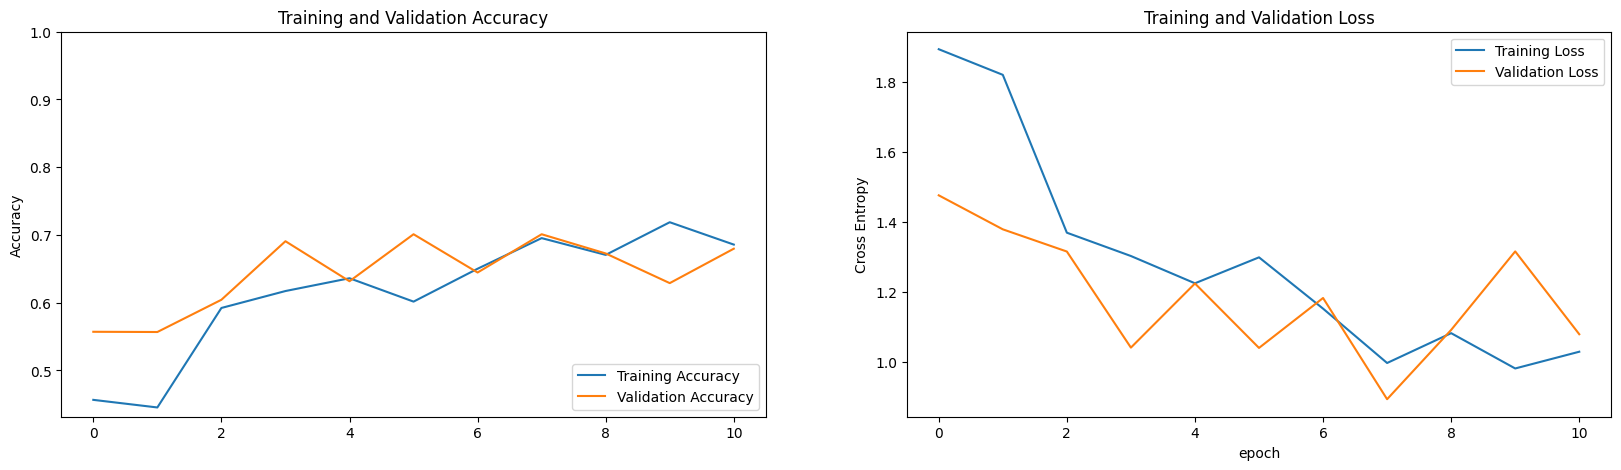

In [23]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

## Stage 2: Finetuning

In [24]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True

In [25]:
from tensorflow.keras.optimizers import SGD
model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [26]:
history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 11/30


W0000 00:00:1722359593.029792     423 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/141 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.4970 - loss: 1.8094

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


101/141 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.5088 - loss: 1.7606

W0000 00:00:1722360036.727976     423 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5203 - loss: 1.7132

W0000 00:00:1722360185.642705     421 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 11: val_loss improved from inf to 1.08643, saving model to Models/Xception/fine_tune_model_best.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 706s 4s/step - accuracy: 0.5206 - loss: 1.7120 - val_accuracy: 0.6867 - val_loss: 1.0864
Epoch 12/30
  1/141 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - accuracy: 0.6172 - loss: 1.2437

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1722360225.112901     424 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 12: val_loss did not improve from 1.08643
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6172 - loss: 1.2437 - val_accuracy: 0.7216 - val_loss: 1.1252
Epoch 13/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6455 - loss: 1.2327
Epoch 13: val_loss did not improve from 1.08643
141/141 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 0.6456 - loss: 1.2325 - val_accuracy: 0.6910 - val_loss: 1.1003
Epoch 13: early stopping


In [27]:
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

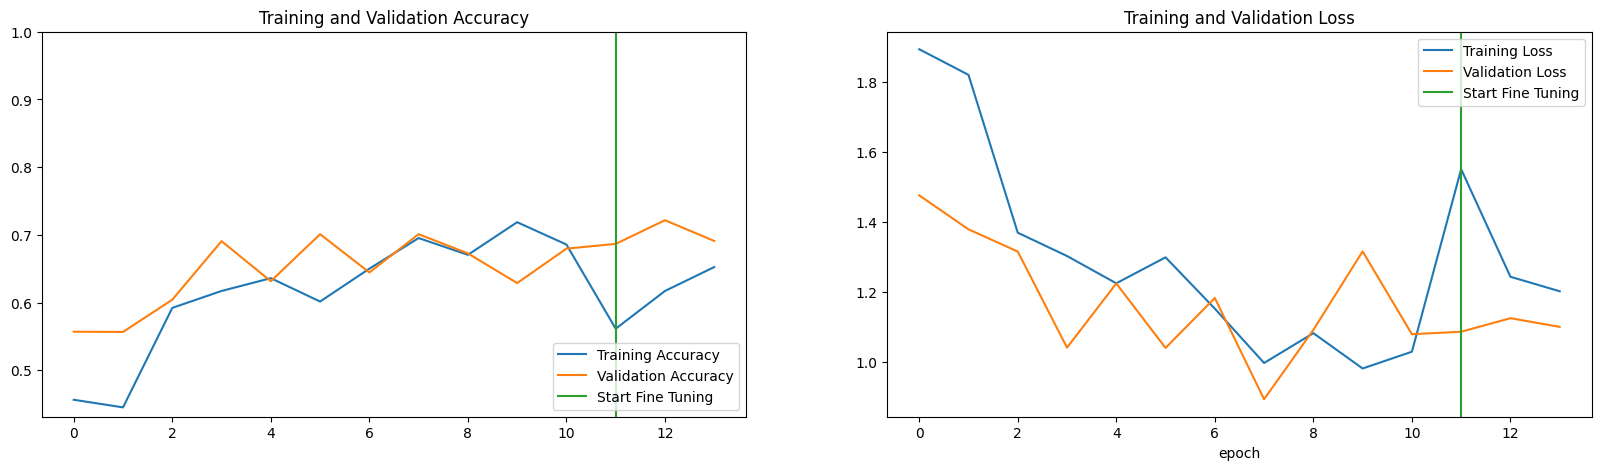

In [28]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS - 4, INITIAL_EPOCHS - 4], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([INITIAL_EPOCHS - 4, INITIAL_EPOCHS - 4], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(FINE_TUNE_MODE_FIG)
plt.show()

## Eval

In [35]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

39/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6869 - loss: 1.0518

2024-07-30 18:15:28.590220: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[124,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[124,64,147,147]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-30 18:15:29.534376: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.944277851s
Trying algorithm eng3{k11=2} for conv (f32[124,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[124,64,147,147]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a wh

40/40 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.6865 - loss: 1.0538
Test accuracy: 0.6788506507873535


In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tqdm.notebook import tqdm
validate_results = {}
test_results = {}

In [43]:
print('\n========== Evaluate', folder, 'Model ==========')
model = load_model('/kaggle/working/Models/Xception/fine_tune_model_best.keras')
model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9),
    loss = 'categorical_crossentropy', 
    metrics = [
        'accuracy', 
        TopKCategoricalAccuracy(k=3, name='top_3_accuracy'), 
        TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)
print('Validate dataset:')
validate_results[folder] = model.evaluate(generated_validate_data)
print('Test dataset:', )
test_results[folder] = model.evaluate(generated_test_data)


========== Evaluate Xception Model ==========
Validate dataset:


W0000 00:00:1722364383.614652     422 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6705 - loss: 1.0959 - top_3_accuracy: 0.8633 - top_5_accuracy: 0.9334

W0000 00:00:1722364419.940080     424 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6721 - loss: 1.0952 - top_3_accuracy: 0.8633 - top_5_accuracy: 0.9327
Test dataset:
40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6780 - loss: 1.1050 - top_3_accuracy: 0.8660 - top_5_accuracy: 0.9189


In [44]:
test_report = pd.DataFrame.from_dict(test_results, orient='index').iloc[:, 1:]
test_report.columns = ['Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy']
test_report.sort_values(by=['Accuracy'], ascending=False)

,Accuracy,Top 3 Accuracy,Top 5 Accuracy
Xception,0.683346,0.868843,0.923964


## Inference

In [66]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np

def load_and_preprocess_image(img_path, target_size=IMAGE_SIZE):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [64]:
def predict_image(img_path):
    preprocessed_img = load_and_preprocess_image(img_path)
    
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    confidence = predictions[0][predicted_class_index]
    
    return predicted_class_index, confidence

In [69]:
img_path = '/kaggle/input/custom-food-dataset/FOOD-DATASET/TEST/Bánh mì cay/10.jpg'
predicted_class, confidence = predict_image(img_path)

In [70]:
print(f"Predicted class index: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

In [76]:
label2id = generated_train_data.class_indices
id2label = {label2id[label]: label for label in label2id.keys()}

In [85]:
id2label[predicted_class]

'Bánh mì cay'